In [42]:
import json
import jsonlines

import faiss
import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt

from code.faiss.lut import LUT
from code.fasttext.embedding_utils import TableEncoder, compare_embeddings
from code.utils.settings import DefaultPath
from code.utils.utils import rebuild_table

from code.utils.global_matching_strategies import simmetric_best_match, stable_marriage

## Comparisons on Sloth Results and embeddings similarities

In [43]:
sloth_results = pl.scan_csv(
    source=DefaultPath.data_path.wikitables + 'threshold-r5-c2-a50/sloth-results-r5-c2-a50.csv'
    ).sort(by=['a%', 'o_a', 'jsim'], descending=[True, True, True])

In [44]:
def retrive_tables_in_jsonl(table_ids:str|list[str],
                           source=DefaultPath.data_path.wikitables + 'threshold-r5-c2-a50/sloth-tables-r5-c2-a50.jsonl'):
    rv = {}
    table_ids = set(table_ids)
    with jsonlines.open(source) as reader:
        for json_table in reader:
            if json_table['_id'] in table_ids:
                table_ids.remove(json_table['_id'])
                rv[json_table['_id']] = json_table
                if table_ids == set():
                    return rv    
        return rv

In [47]:
TableEncoder.available_models

{'cc.en.300.compressed': '/home/giovanni/unimore/TESI/src/models/fastText/cc.en.300.compressed.bin',
 'ft_cc.en.300_freqprune_400K_100K_pq_300': '/home/giovanni/unimore/TESI/src/models/fastText/ft_cc.en.300_freqprune_400K_100K_pq_300.bin'}

In [48]:
tabenc = TableEncoder()

In [49]:
import itertools

# intervals = [(0, 0.4), (0.4, 0.6), (0.6, 0.85), (0.85, 1)]
intervals = [(0, 0.5), (0.75, 1)]

classes = list(itertools.product(intervals, repeat=2))

samples_size = 100
samples_ids = []
samples = {}

for (a_lim, jsim_lim) in classes:
    sample = sloth_results.filter(
        (pl.col('a%') >= a_lim[0]) & (pl.col('a%') < a_lim[1]) & \
        (pl.col('jsim') >= jsim_lim[0]) & (pl.col('jsim') < jsim_lim[1])
    )
    sample = sample.sample(min([samples_size, sample.shape[0]]))
    print(a_lim, '\t', jsim_lim, '\t', min([samples_size, sample.shape[0]]))
    samples[(a_lim, jsim_lim)] = sample
    
    samples_ids += [id for row in sample.iter_rows() for id in row[:2]]

(0, 0.5) 	 (0, 0.5) 	 100
(0, 0.5) 	 (0.75, 1) 	 100
(0.75, 1) 	 (0, 0.5) 	 12
(0.75, 1) 	 (0.75, 1) 	 100


In [50]:
jtables = retrive_tables_in_jsonl(samples_ids)
tables = dict(map(lambda r: (r[0], rebuild_table(r[1])), jtables.items()))

In [60]:
metadata = pd.DataFrame(columns=['a_lim', 'jsim_lim', 'sample size', '#rows', '#cols'])
for (a_lim, jsim_lim) in classes:
    sample = samples[(a_lim, jsim_lim)]
    nrows, ncols = 0, 0
    for row in sample.iter_rows():
        rt = tables[row[0]]
        st = tables[row[1]]
        nrows += rt.shape[0] + st.shape[0]
        ncols += rt.shape[1] + st.shape[1]
    metadata.loc[len(metadata)] = [a_lim, jsim_lim, sample.shape[0], nrows, ncols]
metadata

,a_lim,jsim_lim,sample size,#rows,#cols
0,"(0, 0.5)","(0, 0.5)",100,2988,2032
1,"(0, 0.5)","(0.75, 1)",100,3529,2279
2,"(0.75, 1)","(0, 0.5)",12,525,166
3,"(0.75, 1)","(0.75, 1)",100,5222,758


Reducing numbers of compared columns

In [63]:
# leverage on #columns
new_samples = {}
column_threshold = 300

for cls in classes:
    sample = samples[cls]
    new_sample = pl.DataFrame(schema=sample.schema)
    n = 0
    for row in sample.iter_rows():
        n += tables[row[0]].shape[1] + tables[row[1]].shape[1]
        new_sample.vstack(pl.DataFrame(dict(zip(sample.columns, row))), in_place=True)
        if n > column_threshold:
            break
    new_samples[cls] = new_sample

In [64]:
new_metadata = pd.DataFrame(columns=['a_lim', 'jsim_lim', 'sample size', '#rows', '#cols'])
for (a_lim, jsim_lim) in classes:
    sample = new_samples[(a_lim, jsim_lim)]
    nrows, ncols = 0, 0
    for row in sample.iter_rows():
        rt = tables[row[0]]
        st = tables[row[1]]
        nrows += rt.shape[0] + st.shape[0]
        ncols += rt.shape[1] + st.shape[1]
    new_metadata.loc[len(new_metadata)] = [a_lim, jsim_lim, sample.shape[0], nrows, ncols]
new_metadata

,a_lim,jsim_lim,sample size,#rows,#cols
0,"(0, 0.5)","(0, 0.5)",15,435,336
1,"(0, 0.5)","(0.75, 1)",13,480,306
2,"(0.75, 1)","(0, 0.5)",12,525,166
3,"(0.75, 1)","(0.75, 1)",54,2811,304


In [65]:
from collections import defaultdict
from tqdm.notebook import tqdm

column_comparisons = defaultdict(list)

for (a_lim, jsim_lim) in tqdm(classes, total=len(classes)):
    sample = new_samples[(a_lim, jsim_lim)]
    for row in sample.iter_rows():
        c = compare_embeddings(
                tables[row[0]], tables[row[1]],
                tabenc,
                on='columns',
                add_label=[True, False],
                remove_numbers=[True, False]                
        )

        column_comparisons[(a_lim, jsim_lim, False, False)] += [stable_marriage(c[['C1', 'C2', 'cosine similarity']],               ['C1', 'C2', 'cosine similarity'])]
        column_comparisons[(a_lim, jsim_lim, False, True)] +=  [stable_marriage(c[['C1', 'C2', 'cosine similarity-nonum']],         ['C1', 'C2', 'cosine similarity-nonum'])]
        column_comparisons[(a_lim, jsim_lim, True,  False)] += [stable_marriage(c[['C1', 'C2', 'cosine similarity-wlabel']],        ['C1', 'C2', 'cosine similarity-wlabel'])]
        column_comparisons[(a_lim, jsim_lim, True,  True)] +=  [stable_marriage(c[['C1', 'C2', 'cosine similarity-wlabel-nonum']],  ['C1', 'C2', 'cosine similarity-wlabel-nonum'])]

  0%|          | 0/4 [00:00<?, ?it/s]

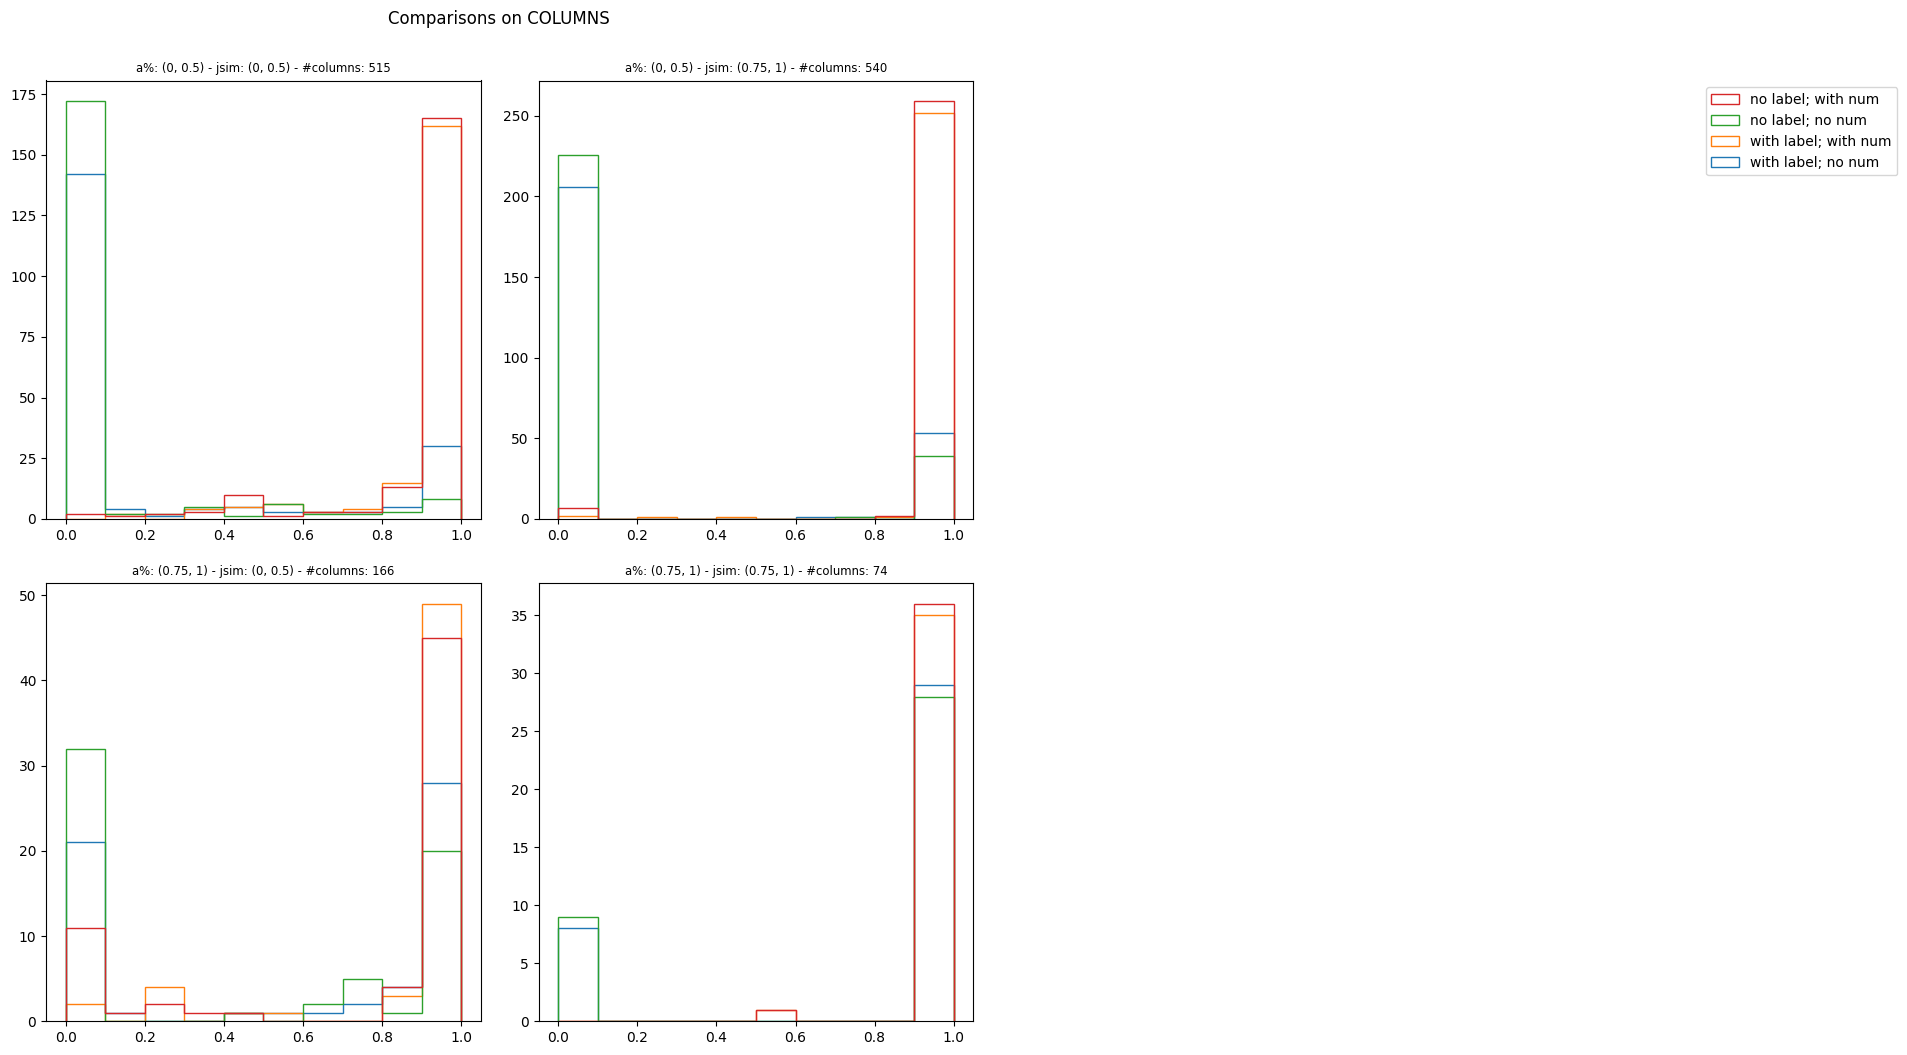

In [57]:
fig, axis = plt.subplots(len(intervals), len(intervals), figsize=(10, 10), constrained_layout=True)
fig.tight_layout(h_pad=2.5)

for i in range(len(intervals)):
    for j in range(len(intervals)):
        for add_label, remove_numbers in itertools.product([True, False], [True, False]):
            try:
                m = len(intervals) * i + j
                cls = classes[m]
                ax = axis[i][j]
                # ax.set_xlim(0, 1.1)
                label = f"{'with label' if add_label else 'no label'}; {'no num' if remove_numbers else 'with num'}"
                
                ncols = int(new_metadata[(new_metadata['a_lim'] == cls[0]) & (new_metadata['jsim_lim'] == cls[1])]['#cols'])
                ax.set_title(f"a%: {cls[0]} - jsim: {cls[1]} - #columns: {ncols}", fontsize='small')
                
                comp = pd.concat(column_comparisons[(cls[0], cls[1], add_label, remove_numbers)])


                ax.hist(
                    comp.sort_values(by=comp.columns[2]).fillna(0)[comp.columns[2]],
                    bins=np.arange(0, 1.1, 0.1),
                    fill=False, 
                    label=label,
                    histtype='step',
                    )
            except: continue
axis[0][0].legend(bbox_to_anchor=(axis[0][-1].get_position().get_points()[1][0] + 3.3, 1), reverse=True)
fig.suptitle('Comparisons on COLUMNS', y=1.05)
plt.show()

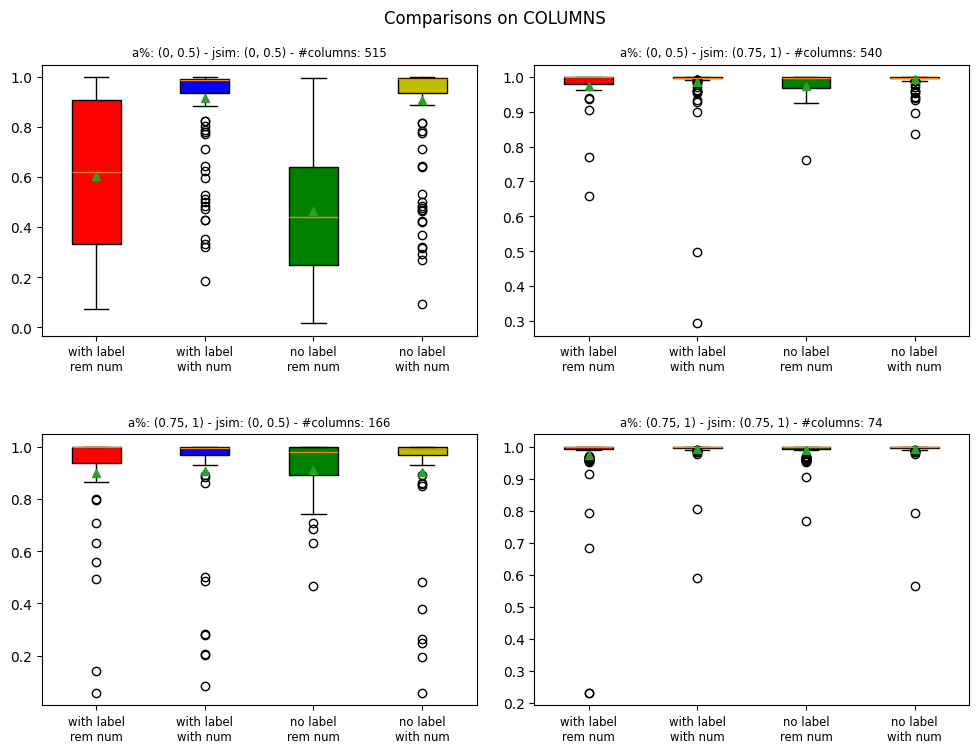

In [80]:
fig, axis = plt.subplots(len(intervals), len(intervals), figsize=(10, 7))
fig.tight_layout(h_pad=5)
colors = ['r', 'b', 'g', 'y']

labels = [f"{'with label' if add_label else 'no label'}\n{'rem num' if remove_numbers else 'with num'}" for add_label, remove_numbers in itertools.product([True, False], [True, False])]

for i in range(len(intervals)):
    for j in range(len(intervals)):
        m = len(intervals) * i + j
        cls = classes[m]
        ax = axis[i][j]
        nrows = int(new_metadata[(new_metadata['a_lim'] == cls[0]) & (new_metadata['jsim_lim'] == cls[1])]['#cols'])
        ax.set_title(f"a%: {cls[0]} - jsim: {cls[1]} - #columns: {nrows}", fontsize='small')

            
        data = [pd.concat(column_comparisons[(cls[0], cls[1], add_label, remove_numbers)]).iloc[:, -1]
                for add_label, remove_numbers in itertools.product([True, False], [True, False])
                ]
        for d in data:        
            d.dropna(inplace=True)
        bplot = ax.boxplot(data, vert=True, patch_artist=True, showmeans=True, showfliers=True)

        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(labels, fontsize='small')


fig.suptitle('Comparisons on COLUMNS', y=1.05)
plt.show()

## On Rows

In [59]:
metadata

,a_lim,jsim_lim,sample size,#rows,#cols
0,"(0, 0.5)","(0, 0.5)",100,2988,2032
1,"(0, 0.5)","(0.75, 1)",100,3529,2279
2,"(0.75, 1)","(0, 0.5)",12,525,166
3,"(0.75, 1)","(0.75, 1)",100,5222,758


In [69]:
# leverage on #rows
new_samples = {}
row_threshold = 700

for cls in classes:
    sample = samples[cls]
    new_sample = pl.DataFrame(schema=sample.schema)
    nrows = 0
    for row in sample.iter_rows():
        nrows += tables[row[0]].shape[0] + tables[row[1]].shape[0]
        new_sample.vstack(pl.DataFrame(dict(zip(sample.columns, row))), in_place=True)
        if nrows > row_threshold:
            break
    new_samples[cls] = new_sample

In [70]:
new_metadata = pd.DataFrame(columns=['a_lim', 'jsim_lim', 'sample size', '#rows', '#cols'])
for (a_lim, jsim_lim) in classes:
    sample = new_samples[(a_lim, jsim_lim)]
    nrows, ncols = 0, 0
    for row in sample.iter_rows():
        rt = tables[row[0]]
        st = tables[row[1]]
        nrows += rt.shape[0] + st.shape[0]
        ncols += rt.shape[1] + st.shape[1]
    new_metadata.loc[len(new_metadata)] = [a_lim, jsim_lim, sample.shape[0], nrows, ncols]
new_metadata

,a_lim,jsim_lim,sample size,#rows,#cols
0,"(0, 0.5)","(0, 0.5)",25,717,515
1,"(0, 0.5)","(0.75, 1)",22,721,540
2,"(0.75, 1)","(0, 0.5)",12,525,166
3,"(0.75, 1)","(0.75, 1)",14,729,74


In [72]:
from collections import defaultdict
from tqdm.notebook import tqdm

row_comparisons = defaultdict(list)

for (a_lim, jsim_lim) in tqdm(classes, total=len(classes)):
    sample = new_samples[(a_lim, jsim_lim)]
    for row in sample.iter_rows():
        c = compare_embeddings(
                tables[row[0]], tables[row[1]],
                tabenc,
                on='rows',
                add_label=[True, False],
                remove_numbers=[True, False]
        )

        #           a_lim   jsim_lim  add_label remove_num
        row_comparisons[(a_lim, jsim_lim, False, False)] += [stable_marriage(c[['R1', 'R2', 'cosine similarity']],               ['R1', 'R2', 'cosine similarity'])]
        row_comparisons[(a_lim, jsim_lim, False, True)] +=  [stable_marriage(c[['R1', 'R2', 'cosine similarity-nonum']],         ['R1', 'R2', 'cosine similarity-nonum'])]
        row_comparisons[(a_lim, jsim_lim, True,  False)] += [stable_marriage(c[['R1', 'R2', 'cosine similarity-wlabel']],        ['R1', 'R2', 'cosine similarity-wlabel'])]
        row_comparisons[(a_lim, jsim_lim, True,  True)] +=  [stable_marriage(c[['R1', 'R2', 'cosine similarity-wlabel-nonum']],  ['R1', 'R2', 'cosine similarity-wlabel-nonum'])]

  0%|          | 0/4 [00:00<?, ?it/s]

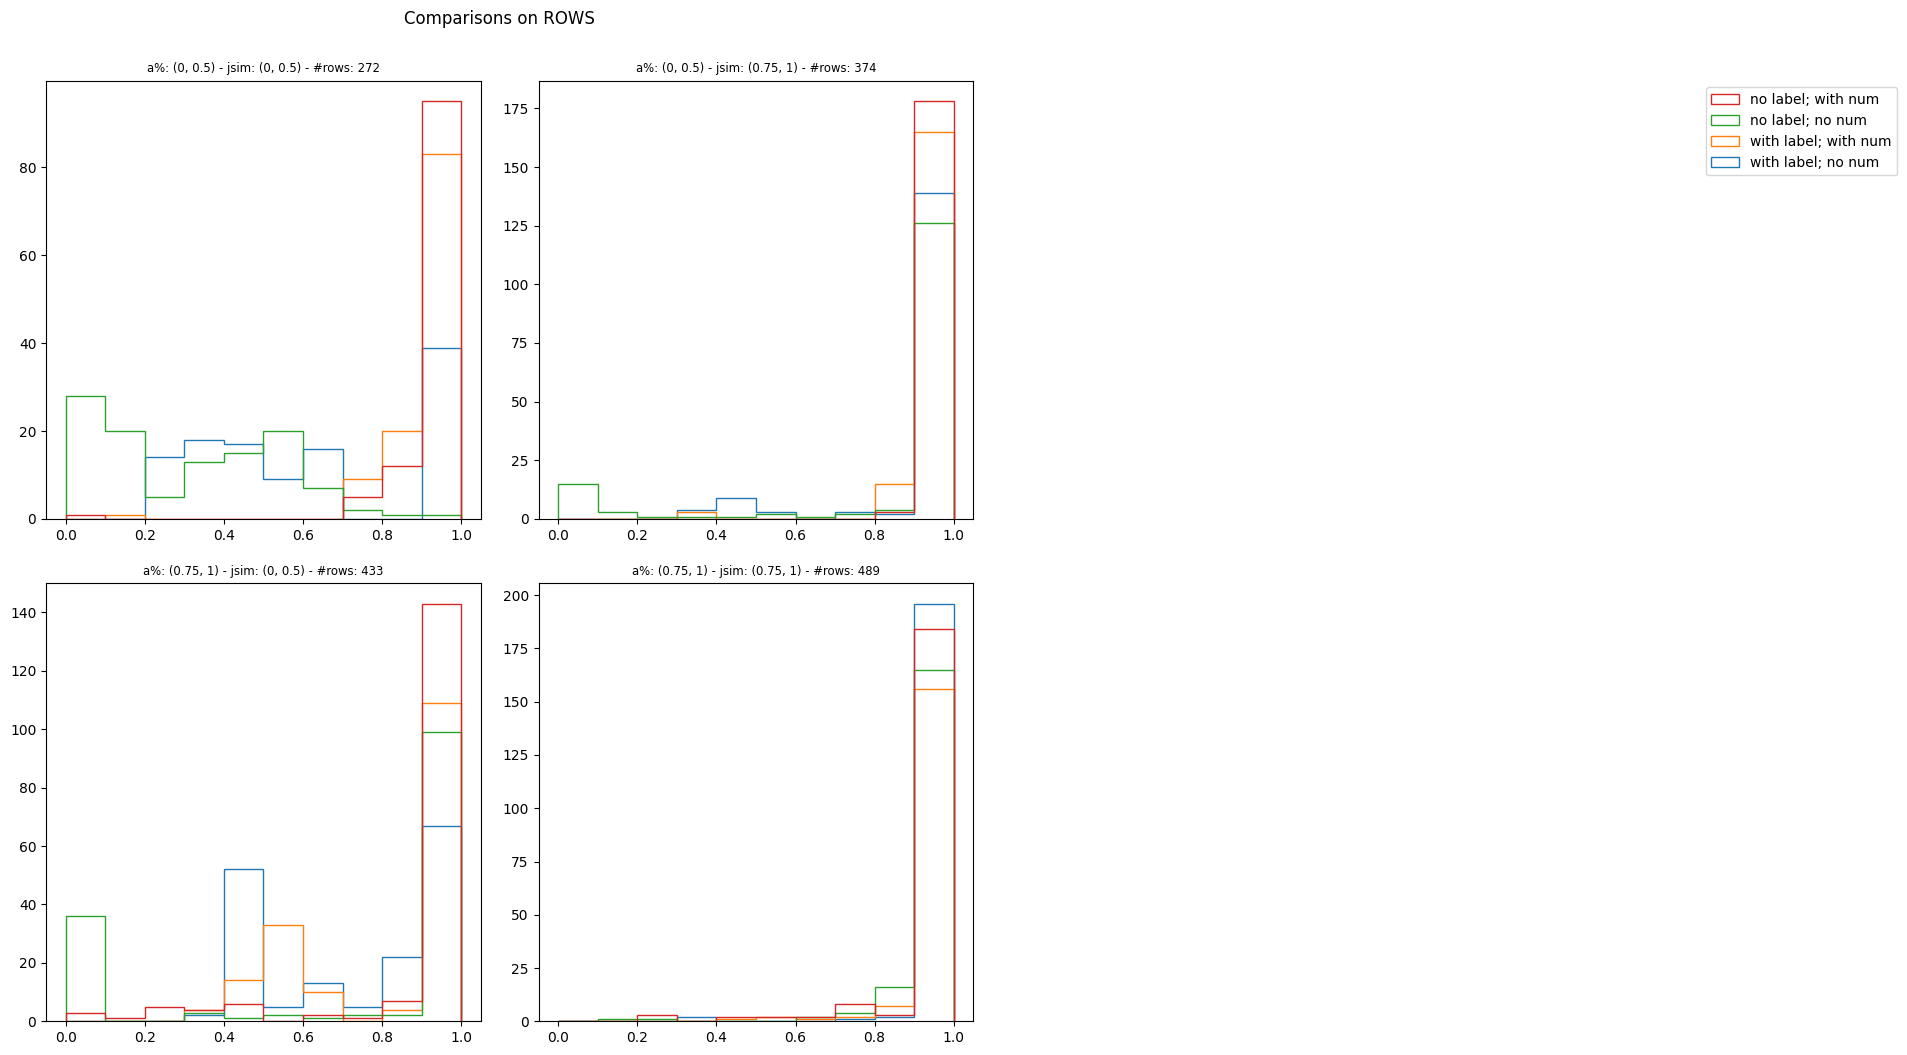

In [12]:
import numpy as np


fig, axis = plt.subplots(len(intervals), len(intervals), figsize=(10, 10), constrained_layout=True)
fig.tight_layout(h_pad=2.5)

for i in range(len(intervals)):
    for j in range(len(intervals)):
        for add_label, remove_numbers in itertools.product([True, False], [True, False]):
            try:
                m = len(intervals) * i + j
                cls = classes[m]
                ax = axis[i][j]
                # ax.set_xlim(0, 1.1)

                nrows = int(metadata[(metadata['a_lim'] == cls[0]) & (metadata['jsim_lim'] == cls[1])]['#rows'])
                ax.set_title(f"a%: {cls[0]} - jsim: {cls[1]} - #rows: {nrows}", fontsize='small')
                
                label = f"{'with label' if add_label else 'no label'}; {'no num' if remove_numbers else 'with num'}"

                comp = pd.concat(row_comparisons[(cls[0], cls[1], add_label, remove_numbers)])
                ax.hist(
                    comp.sort_values(by=comp.columns[2]).fillna(0)[comp.columns[2]],
                    bins=np.arange(0, 1.1, 0.1),
                    fill=False, 
                    label=label,
                    histtype='step',
                    )
            except: continue
axis[0][0].legend(bbox_to_anchor=(axis[0][-1].get_position().get_points()[1][0] + 3.3, 1), reverse=True)
fig.suptitle('Comparisons on ROWS', y=1.05)
plt.show()

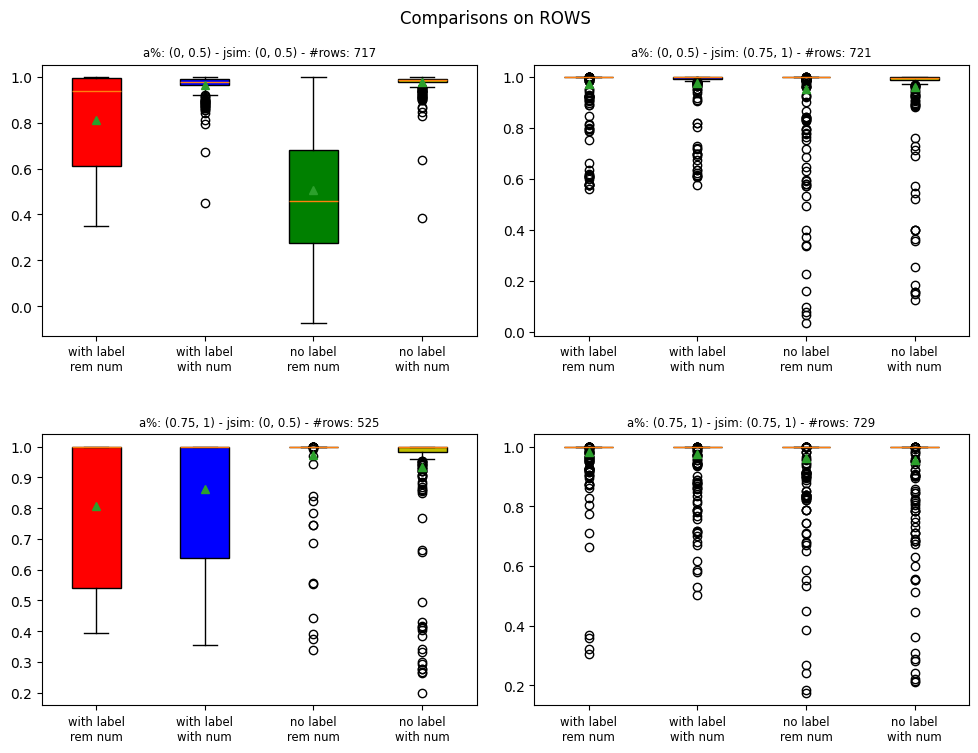

In [79]:
fig, axis = plt.subplots(len(intervals), len(intervals), figsize=(10, 7))
fig.tight_layout(h_pad=5)
colors = ['r', 'b', 'g', 'y']

labels = [f"{'with label' if add_label else 'no label'}\n{'rem num' if remove_numbers else 'with num'}" for add_label, remove_numbers in itertools.product([True, False], [True, False])]

for i in range(len(intervals)):
    for j in range(len(intervals)):
        m = len(intervals) * i + j
        cls = classes[m]
        ax = axis[i][j]
        nrows = int(new_metadata[(new_metadata['a_lim'] == cls[0]) & (new_metadata['jsim_lim'] == cls[1])]['#rows'])
        ax.set_title(f"a%: {cls[0]} - jsim: {cls[1]} - #rows: {nrows}", fontsize='small')

            
        data = [pd.concat(row_comparisons[(cls[0], cls[1], add_label, remove_numbers)]).iloc[:, -1]
                for add_label, remove_numbers in itertools.product([True, False], [True, False])
                ]
        for d in data:        
            d.dropna(inplace=True)
        bplot = ax.boxplot(data, vert=True, patch_artist=True, showmeans=True, showfliers=True)

        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(labels, fontsize='small')


fig.suptitle('Comparisons on ROWS', y=1.05)
plt.show()